In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score


In [5]:

df = pd.read_csv('../data/sell-in.txt', sep='\t')
df_productos_predecir = pd.read_csv('../data/product_id_apredecir201912.txt', sep='\t')

In [6]:
df.head()

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn
0,201701,10234,20524,0,2,0.05300,0.05300
1,201701,10032,20524,0,1,0.13628,0.13628
2,201701,10217,20524,0,1,0.03028,0.03028
3,201701,10125,20524,0,1,0.02271,0.02271
4,201701,10012,20524,0,11,1.54452,1.54452


In [7]:
#Filter df to contain only products that are in df_productos_predecir
product_ids_to_predict = df_productos_predecir['product_id'].unique()
df = df[df['product_id'].isin(product_ids_to_predict)]

print(f"Original df shape after filtering: {df.shape}")
print(f"Unique products in df_productos_predecir: {len(product_ids_to_predict)}")
print(f"Unique products in filtered df: {df['product_id'].nunique()}")

Original df shape after filtering: (2293481, 7)
Unique products in df_productos_predecir: 780
Unique products in filtered df: 780


In [8]:
df.head()

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn
0,201701,10234,20524,0,2,0.05300,0.05300
1,201701,10032,20524,0,1,0.13628,0.13628
2,201701,10217,20524,0,1,0.03028,0.03028
3,201701,10125,20524,0,1,0.02271,0.02271
4,201701,10012,20524,0,11,1.54452,1.54452


In [9]:
pivot_df = df.pivot_table(
    index=['customer_id', 'product_id'],
    columns='periodo',
    values='tn',
    aggfunc='sum'
).reset_index()

In [10]:
pivot_df.head()

periodo,customer_id,product_id,201701,201702,201703,201704,201705,201706,201707,201708,...,201903,201904,201905,201906,201907,201908,201909,201910,201911,201912
0,10001,20001,99.43861,198.84365,92.46537,13.29728,101.00563,128.04792,101.20711,43.33930,...,130.54927,364.37071,439.90647,65.92436,144.78714,33.63991,109.05244,176.02980,236.65556,180.21938
1,10001,20002,87.64856,66.08396,75.09182,49.51494,122.40283,167.46470,156.15120,18.15133,...,220.19153,155.81927,264.55349,151.12081,103.12062,148.91108,213.36148,430.90803,547.87849,334.03714
2,10001,20003,100.21284,126.97776,114.52896,37.34640,76.66386,108.30456,87.14160,43.57080,...,125.49948,86.54509,74.71874,78.79703,105.81480,121.06458,101.61982,196.18531,135.69192,137.98717
3,10001,20004,21.73954,29.76246,42.54996,9.31694,8.33349,10.92153,15.01063,12.42259,...,25.94769,17.84712,27.99741,34.26047,16.04585,8.33349,20.57492,37.88891,27.58851,12.94020
4,10001,20005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.66966,1.72238,4.25654,3.20851,5.41195,2.51269,5.66966,7.98907,11.01719,7.66693


In [11]:
# Fill NaN values following the rule: keep NaN for values before the first non-null value in each row
def fill_nans_after_first_value(row):
    # Get the time series columns (excluding customer_id and product_id)
    time_columns = row.index[2:]  # Assuming first 2 columns are customer_id and product_id
    
    # Find the first non-null index
    first_non_null_idx = None
    for idx in time_columns:
        if pd.notna(row[idx]):
            first_non_null_idx = idx
            break
    
    # If no non-null value found, return the row as is
    if first_non_null_idx is None:
        return row
    
    # Fill NaN values with 0 only after the first non-null value
    first_non_null_position = time_columns.get_loc(first_non_null_idx)
    for i in range(first_non_null_position + 1, len(time_columns)):
        col = time_columns[i]
        if pd.isna(row[col]):
            row[col] = 0
    
    return row

# Apply the function to fill NaN values
pivot_df_filled = pivot_df.apply(fill_nans_after_first_value, axis=1)

In [12]:
pivot_df_filled.head()

periodo,customer_id,product_id,201701,201702,201703,201704,201705,201706,201707,201708,...,201903,201904,201905,201906,201907,201908,201909,201910,201911,201912
0,10001.0,20001.0,99.43861,198.84365,92.46537,13.29728,101.00563,128.04792,101.20711,43.33930,...,130.54927,364.37071,439.90647,65.92436,144.78714,33.63991,109.05244,176.02980,236.65556,180.21938
1,10001.0,20002.0,87.64856,66.08396,75.09182,49.51494,122.40283,167.46470,156.15120,18.15133,...,220.19153,155.81927,264.55349,151.12081,103.12062,148.91108,213.36148,430.90803,547.87849,334.03714
2,10001.0,20003.0,100.21284,126.97776,114.52896,37.34640,76.66386,108.30456,87.14160,43.57080,...,125.49948,86.54509,74.71874,78.79703,105.81480,121.06458,101.61982,196.18531,135.69192,137.98717
3,10001.0,20004.0,21.73954,29.76246,42.54996,9.31694,8.33349,10.92153,15.01063,12.42259,...,25.94769,17.84712,27.99741,34.26047,16.04585,8.33349,20.57492,37.88891,27.58851,12.94020
4,10001.0,20005.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.66966,1.72238,4.25654,3.20851,5.41195,2.51269,5.66966,7.98907,11.01719,7.66693


In [13]:
# filtered_df = pivot_df_filled[pivot_df_filled['product_id'].isin([20001, 20002, 20003, 20004, 20005, 20006, 20007, 20008, 20009, 20010, 20011, 20012, 20013, 20014, 20015, 20016, 20017, 20018, 20019, 20020])]
# print(f"Filtered dataframe shape: {filtered_df.shape}")
# print(filtered_df.head())

In [14]:

# Prepare data for training linear regression models
def train_linear_regression_per_series(df):
    """
    Train a linear regression model for each customer-product combination
    Using data up to 201910 to predict 201912
    """
    results = []
    
    # Get time period columns (excluding customer_id and product_id)
    time_columns = [col for col in df.columns if col not in ['customer_id', 'product_id']]
    
    # Training periods (up to 201910)
    train_periods = [col for col in time_columns if int(col) <= 201910]
    
    for idx, row in df.iterrows():
        customer_id = row['customer_id']
        product_id = row['product_id']
        
        # Get training data (non-null values up to 201910)
        train_data = []
        train_values = []
        
        for i, period in enumerate(train_periods):
            if pd.notna(row[period]):
                train_data.append(i)  # Use period index as feature
                train_values.append(row[period])
        
        # Skip if insufficient data points
        if len(train_data) < 3:
            continue
            
        # Prepare arrays for sklearn
        X_train = np.array(train_data).reshape(-1, 1)
        y_train = np.array(train_values)
        
        # Train linear regression model
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        # Predict for 201912 (index would be the position of 201912 in time_columns)
        period_201912_idx = time_columns.index(201912)
        X_pred = np.array([[period_201912_idx]])
        y_pred = model.predict(X_pred)[0]
        
        # Get actual value for 201912 if available
        actual_201912 = row[201912] if pd.notna(row[201912]) else None
        
        # Calculate model performance on training data
        y_train_pred = model.predict(X_train)
        train_r2 = r2_score(y_train, y_train_pred)
        train_mse = mean_squared_error(y_train, y_train_pred)
        
        results.append({
            'customer_id': customer_id,
            'product_id': product_id,
            'predicted_201912': y_pred,
            'actual_201912': actual_201912,
            'train_r2': train_r2,
            'train_mse': train_mse,
            'train_points': len(train_data),
            'slope': model.coef_[0],
            'intercept': model.intercept_
        })
    
    return pd.DataFrame(results)

# Train models and make predictions
predictions_df = train_linear_regression_per_series(pivot_df_filled)
print(f"Trained {len(predictions_df)} models")
print("\nFirst 10 predictions:")
print(predictions_df.head(10))

Trained 251016 models

First 10 predictions:
   customer_id  product_id  predicted_201912  actual_201912  train_r2  \
0      10001.0     20001.0        243.756363      180.21938  0.117869   
1      10001.0     20002.0        271.444451      334.03714  0.333539   
2      10001.0     20003.0        113.352250      137.98717  0.001229   
3      10001.0     20004.0         24.892653       12.94020  0.037570   
4      10001.0     20005.0          6.532832        7.66693  0.603161   
5      10001.0     20006.0         -0.405741       15.84069  0.359045   
6      10001.0     20007.0         28.088556       55.22591  0.263781   
7      10001.0     20008.0          6.613405       12.70392  0.336636   
8      10001.0     20009.0         43.076216       74.67156  0.001635   
9      10001.0     20010.0          0.082909        0.00000  0.004505   

      train_mse  train_points     slope   intercept  
0  10111.509105            34  3.746624  112.624529  
1   5322.704100            34  5.260798   8

In [15]:
predicted_sum_df = predictions_df.groupby('product_id', as_index=False)['predicted_201912'].sum()
predicted_sum_df.head(10)

,product_id,predicted_201912
0,20001.0,1628.977594
1,20002.0,1326.310656
2,20003.0,769.110156
3,20004.0,654.641049
4,20005.0,641.231066
5,20006.0,409.896156
6,20007.0,367.204260
7,20008.0,354.544808
8,20009.0,557.556889
9,20010.0,280.101668


In [16]:
actual_sum_df = df[df['periodo'] == 201912].groupby('product_id', as_index=False)['tn'].sum()
actual_sum_df.head()

,product_id,tn
0,20001,1504.68856
1,20002,1087.30855
2,20003,892.50129
3,20004,637.90002
4,20005,593.24443


In [17]:
# Merge the predicted and actual sums on product_id
comparison_df = predicted_sum_df.merge(actual_sum_df, on='product_id', how='inner')

# Calculate error rate (MAPE - Mean Absolute Percentage Error)
comparison_df['error_rate'] = abs((comparison_df['predicted_201912'] - comparison_df['tn']) / comparison_df['tn']) * 100

# Display the comparison with error rates
print("Comparison of Predicted vs Actual with Error Rates:")
print(comparison_df)
print(f"\nMean Error Rate: {comparison_df['error_rate'].mean():.2f}%")
print(f"Median Error Rate: {comparison_df['error_rate'].median():.2f}%")

Comparison of Predicted vs Actual with Error Rates:
     product_id  predicted_201912          tn   error_rate
0       20001.0       1628.977594  1504.68856     8.260117
1       20002.0       1326.310656  1087.30855    21.981075
2       20003.0        769.110156   892.50129    13.825317
3       20004.0        654.641049   637.90002     2.624397
4       20005.0        641.231066   593.24443     8.088847
..          ...               ...         ...          ...
766     21263.0         -0.182032     0.01270  1533.320132
767     21265.0         -0.142201     0.05007   384.003918
768     21266.0         -0.128356     0.05121   350.646730
769     21267.0         -0.120324     0.01569   866.881241
770     21276.0         -0.092581     0.00892  1137.907324

[771 rows x 4 columns]

Mean Error Rate: 244.20%
Median Error Rate: 40.18%


In [18]:
# Group by product_id and periodo, sum the 'tn' values
tn_summary = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()
print("TN values summed by product_id and periodo:")
print(tn_summary)

TN values summed by product_id and periodo:
       product_id  periodo          tn
0           20001   201701   934.77222
1           20001   201702   798.01620
2           20001   201703  1303.35771
3           20001   201704  1069.96130
4           20001   201705  1502.20132
...           ...      ...         ...
22344       21276   201908     0.01265
22345       21276   201909     0.01856
22346       21276   201910     0.02079
22347       21276   201911     0.03341
22348       21276   201912     0.00892

[22349 rows x 3 columns]


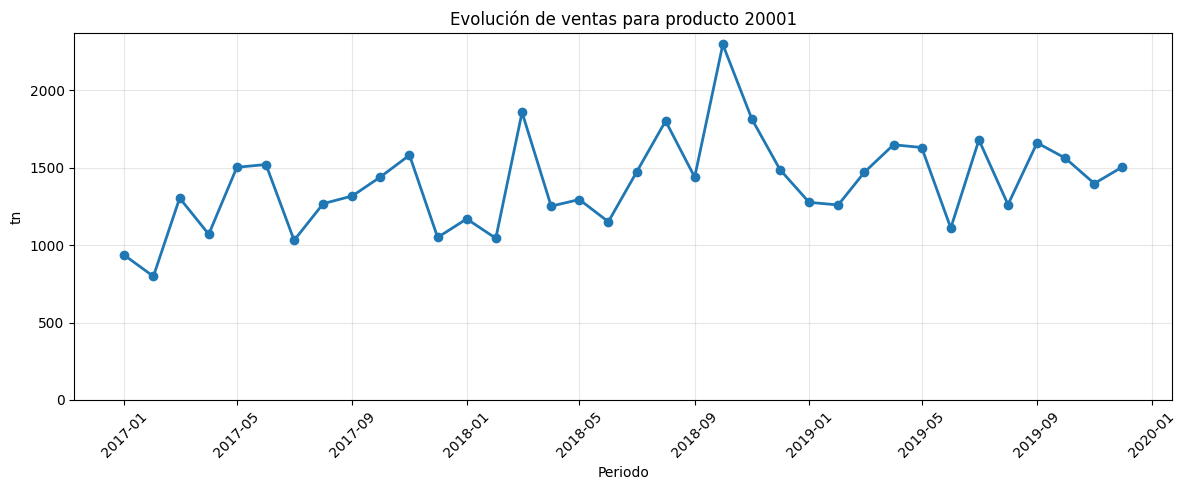

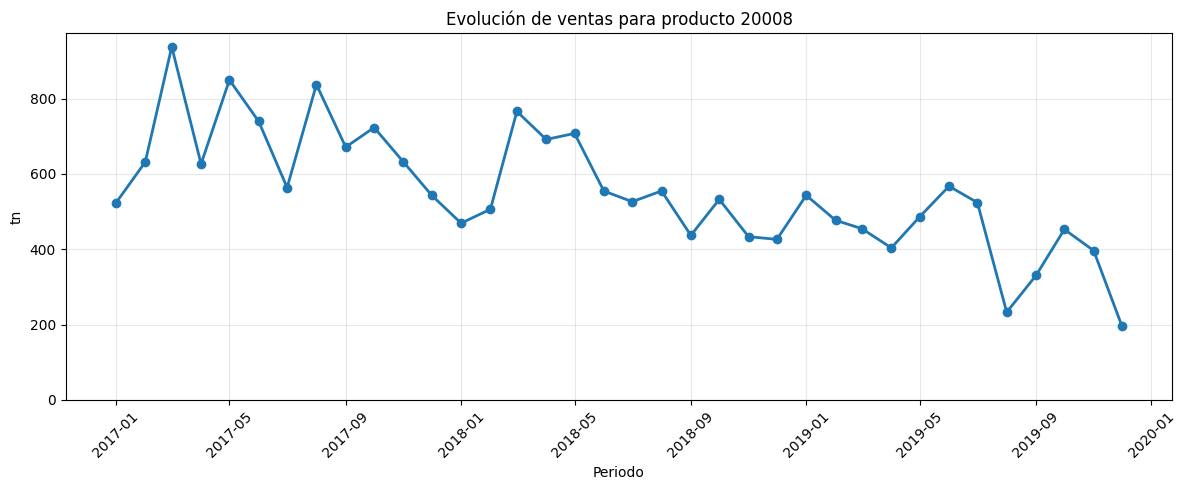

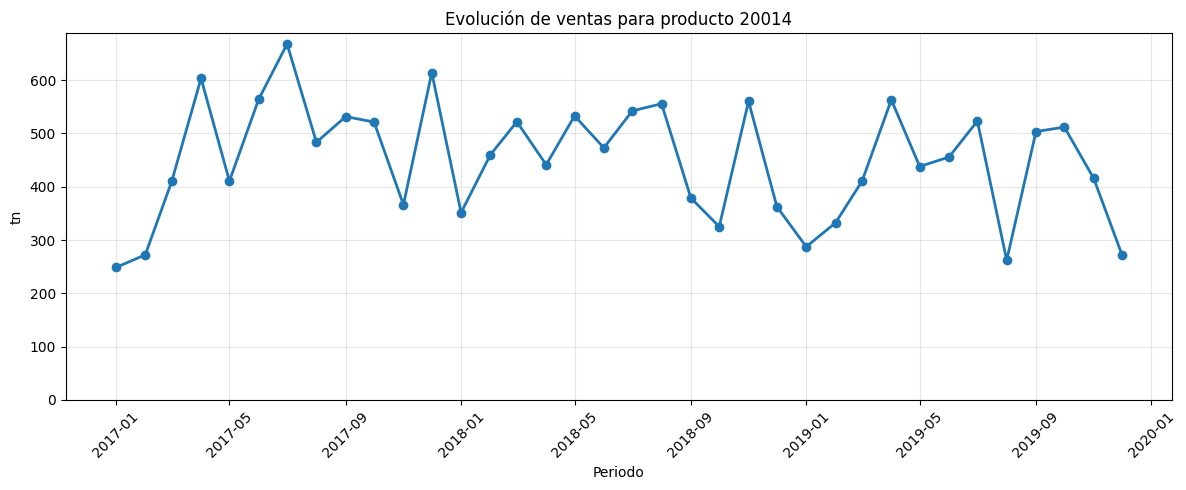

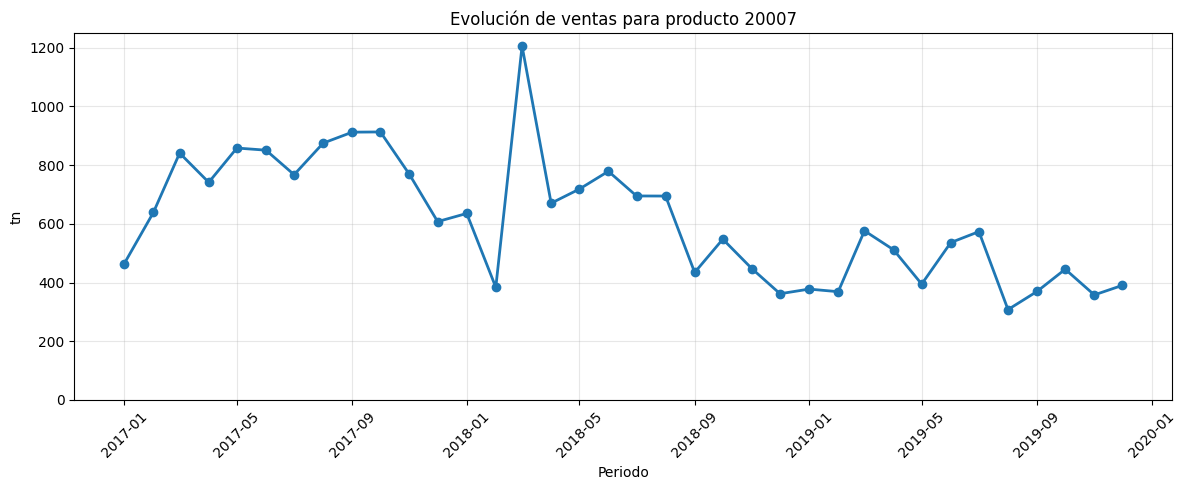

In [19]:
import matplotlib.pyplot as plt

# Define the product IDs to plot
product_ids = [20001, 20008, 20014, 20007]

# Convert periodo to timestamp format
tn_summary['timestamp'] = pd.to_datetime(tn_summary['periodo'], format='%Y%m')

# Update the plotting code to use timestamp and show zero
for pid in product_ids:
    # Filter data for the current product
    product_data = tn_summary[tn_summary['product_id'] == pid].copy()
    
    # Create the plot
    plt.figure(figsize=(12, 5))
    plt.plot(product_data['timestamp'], product_data['tn'], marker='o', linewidth=2)
    plt.title(f'Evolución de ventas para producto {int(pid)}')
    plt.xlabel('Periodo')
    plt.ylabel('tn')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.ylim(bottom=0)  # Start y-axis at 0
    plt.tight_layout()
    plt.show()

In [20]:
comparison_df.to_csv('../data/comparison_lr_predictions_actuals.csv', index=False)